# What's SP500 next day stock price forecast?

## 1. data preparation

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- SP500 historical OHCLV sample:
                   Open         High          Low        Close      Volume
Date                                                                      
2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971   931800000
2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044  1009000000
2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985  1085500000
2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951  1092300000
2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971  1225200000

- close values plot versus normalized (between 0 and 1) close values plot:


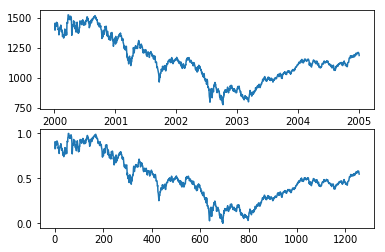

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from aiconf import fit_scaler, scale, prepare_regression_samples, plots

WINDOW = 7
TEST_SIZE = 0.2
RANDOM_SEED = 42 #it makes results reproducible: only for test!!!
#RANDOM_SEED = None #uncomment me for real training!!!
print "- SP500 historical OHCLV sample:"
df = pd.read_csv('/data/historical-SP500.csv', index_col='Date', parse_dates=True).sort_index()
df = df[df.index.values > np.datetime64('2000-01-01')]
close = df['Close'][0:(1250+WINDOW+1)]

fit_scaler(close, TEST_SIZE)
sclose = scale(close)

X,y = prepare_regression_samples(sclose, WINDOW)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, shuffle=True)
print df[["Open", "High", "Low", "Close", "Volume"]].head()
print ""
print "- close values plot versus normalized (between 0 and 1) close values plot:"
plots(close, sclose)


In [2]:
print "-INPUT sample is an array of the last week prices of the given price, OUTPUT is the next day price of the given price:"
print "X:", X[0:2],"\ny:",y[0:2]
print ""
print "- split X, y into test and validation sets (0.20%):"
print "the size of train set (X_train, Y_train) is ", X_train.shape[0], " and the size of validation/test set (X_test, y_test) is", X_test.shape[0]

-INPUT sample is an array of the last week prices of the given price, OUTPUT is the next day price of the given price:
X: [[0.90376982 0.82943929 0.83302253 0.83480749 0.88545358 0.9069402
  0.88157732]
 [0.82943929 0.83302253 0.83480749 0.88545358 0.9069402  0.88157732
  0.87317175]] 
y: [0.87317175 0.89639015]

- split X, y into test and validation sets (0.20%):
the size of train set (X_train, Y_train) is  1000  and the size of validation/test set (X_test, y_test) is 250


## 2. choose, build and compile the model
- which model should you choose?
- How to choose the number of hidden layers and nodes?
- How should I choose a proper activation function for the neural network?
- Which optimizer and error function should I use?
- Which learning rate and error function should I use?

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

#Y = fa(W*X + b)

model = Sequential()
model.add(Dense(64, input_shape = (WINDOW, ), activation="relu", kernel_initializer='normal'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=[])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


## 3. train the model

In [4]:
history = model.fit(
        X_train, y_train, epochs=30, batch_size=32, 
        validation_data=(X_test, y_test), verbose=1)

score = model.evaluate(X_test, y_test, batch_size=32)
print "loss:", score

Train on 1000 samples, validate on 250 samples
Epoch 1/30
1000/1000 [==============================] - 0s 354us/step - loss: 0.0993 - val_loss: 0.0050
Epoch 2/30
1000/1000 [==============================] - 0s 188us/step - loss: 0.0031 - val_loss: 0.0029
Epoch 3/30
1000/1000 [==============================] - 0s 202us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 4/30
1000/1000 [==============================] - 0s 157us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/30
1000/1000 [==============================] - 0s 80us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 6/30
1000/1000 [==============================] - 0s 81us/step - loss: 8.4301e-04 - val_loss: 9.8980e-04
Epoch 7/30
1000/1000 [==============================] - 0s 81us/step - loss: 7.8492e-04 - val_loss: 9.3873e-04
Epoch 8/30
1000/1000 [==============================] - 0s 64us/step - loss: 7.6620e-04 - val_loss: 9.1359e-04
Epoch 9/30
1000/1000 [==============================] - 0s 96us/step - loss: 7.4204e-04 - val_loss: 9

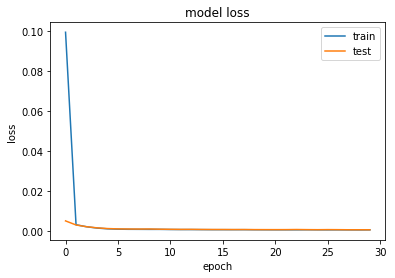

SCORE model 0.00015210342244245111


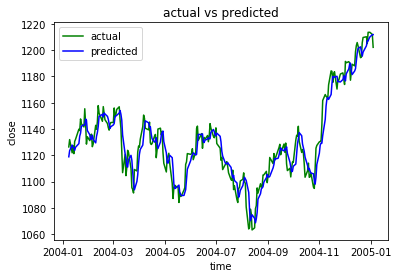

In [5]:
from aiconf import plot_model_performance
#0.0006843569851480425
plot_model_performance(history, model, close, X, y, TEST_SIZE)

## 4. Tuning hyperparameters / hyperparameters optimization
- how I can optimize the performance of the model?
- how I can choose the best values of the model parameters?

In [6]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

def create_model(nodes, optimizer, dropout, init):
    model = Sequential()
    model.add(Dense(nodes, kernel_initializer=init, input_shape = (WINDOW, ), activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, kernel_initializer=init, activation='linear'))
    model.compile(optimizer=optimizer, loss='mse')
    return model 

In [7]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

epochs = [30, 50, 100, 150]
batches = [32, 64, 128, 256, 512]
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
nodes = [32, 64, 256, 512]
dropouts = [0.1, 0.2, 0.25, 3]
init_modes = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

modelf = KerasRegressor(build_fn=create_model, batch_size = 64, nb_epoch = 30, nodes = 512, optimizer='adam', dropout=0.1, init='he_uniform', verbose = 1)

param_grid = {
    #'nb_epoch': epochs,
    'nodes': nodes,
    #'batch_size':batches,
    'optimizer':optimizers,
    #'dropout':dropouts,
    #'init':init_modes,
}

validator = GridSearchCV(estimator=modelf, param_grid=param_grid, n_jobs=1, verbose=2)
grid_result = validator.fit(X, y)
print('The parameters of the best model are: ')
print(validator.best_params_)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] nodes=32, optimizer=SGD .........................................
Epoch 1/1
833/833 [==============================] - 0s 60us/step
[CV] .......................... nodes=32, optimizer=SGD, total=   0.7s
[CV] nodes=32, optimizer=SGD .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


Epoch 1/1
833/833 [==============================] - 0s 29us/step
[CV] .......................... nodes=32, optimizer=SGD, total=   0.4s
[CV] nodes=32, optimizer=SGD .........................................
Epoch 1/1
834/834 [==============================] - 0s 41us/step
[CV] .......................... nodes=32, optimizer=SGD, total=   0.5s
[CV] nodes=32, optimizer=RMSprop .....................................
Epoch 1/1
833/833 [==============================] - 0s 46us/step
[CV] ...................... nodes=32, optimizer=RMSprop, total=   0.6s
[CV] nodes=32, optimizer=RMSprop .....................................
Epoch 1/1
833/833 [==============================] - 0s 50us/step
[CV] ...................... nodes=32, optimizer=RMSprop, total=   0.6s
[CV] nodes=32, optimizer=RMSprop .....................................
Epoch 1/1
834/834 [==============================] - 0s 41us/step
[CV] ...................... nodes=32, optimizer=RMSprop, total=   0.5s
[CV] nodes=32, optimizer=Adagra

833/833 [==============================] - 0s 51us/step
[CV] ...................... nodes=64, optimizer=RMSprop, total=   1.2s
[CV] nodes=64, optimizer=RMSprop .....................................
Epoch 1/1
834/834 [==============================] - 0s 49us/step
[CV] ...................... nodes=64, optimizer=RMSprop, total=   1.2s
[CV] nodes=64, optimizer=Adagrad .....................................
Epoch 1/1
833/833 [==============================] - 0s 45us/step
[CV] ...................... nodes=64, optimizer=Adagrad, total=   1.1s
[CV] nodes=64, optimizer=Adagrad .....................................
Epoch 1/1
833/833 [==============================] - 0s 28us/step
[CV] ...................... nodes=64, optimizer=Adagrad, total=   1.4s
[CV] nodes=64, optimizer=Adagrad .....................................
Epoch 1/1
834/834 [==============================] - 0s 33us/step
[CV] ...................... nodes=64, optimizer=Adagrad, total=   1.0s
[CV] nodes=64, optimizer=Adadelta .......

Epoch 1/1
834/834 [==============================] - 0s 41us/step
[CV] ..................... nodes=256, optimizer=Adagrad, total=   1.5s
[CV] nodes=256, optimizer=Adadelta ...................................
Epoch 1/1
833/833 [==============================] - 0s 38us/step
[CV] .................... nodes=256, optimizer=Adadelta, total=   1.6s
[CV] nodes=256, optimizer=Adadelta ...................................
Epoch 1/1
833/833 [==============================] - 0s 42us/step
[CV] .................... nodes=256, optimizer=Adadelta, total=   1.7s
[CV] nodes=256, optimizer=Adadelta ...................................
Epoch 1/1
834/834 [==============================] - 0s 41us/step
[CV] .................... nodes=256, optimizer=Adadelta, total=   1.7s
[CV] nodes=256, optimizer=Adam .......................................
Epoch 1/1
833/833 [==============================] - 0s 49us/step
[CV] ........................ nodes=256, optimizer=Adam, total=   1.7s
[CV] nodes=256, optimizer=Adam 

[CV] .................... nodes=512, optimizer=Adadelta, total=   2.2s
[CV] nodes=512, optimizer=Adam .......................................
Epoch 1/1
833/833 [==============================] - 0s 55us/step
[CV] ........................ nodes=512, optimizer=Adam, total=   2.7s
[CV] nodes=512, optimizer=Adam .......................................
Epoch 1/1
833/833 [==============================] - 0s 48us/step
[CV] ........................ nodes=512, optimizer=Adam, total=   2.3s
[CV] nodes=512, optimizer=Adam .......................................
Epoch 1/1
834/834 [==============================] - 0s 48us/step
[CV] ........................ nodes=512, optimizer=Adam, total=   2.3s
[CV] nodes=512, optimizer=Adamax .....................................
Epoch 1/1
833/833 [==============================] - 0s 51us/step
[CV] ...................... nodes=512, optimizer=Adamax, total=   2.3s
[CV] nodes=512, optimizer=Adamax .....................................
Epoch 1/1
833/833 [=======

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:  2.2min finished


Epoch 1/1
1250/1250 [==============================] - 2s 1ms/step - loss: 0.5388
The parameters of the best model are: 
{'nodes': 256, 'optimizer': 'RMSprop'}
Best: -0.005926 using {'nodes': 256, 'optimizer': 'RMSprop'}
-0.071576 (0.093799) with: {'nodes': 32, 'optimizer': 'SGD'}
-0.899578 (0.762023) with: {'nodes': 32, 'optimizer': 'RMSprop'}
-0.238992 (0.325009) with: {'nodes': 32, 'optimizer': 'Adagrad'}
-1.413257 (1.476112) with: {'nodes': 32, 'optimizer': 'Adadelta'}
-0.184173 (0.248502) with: {'nodes': 32, 'optimizer': 'Adam'}
-0.189201 (0.255351) with: {'nodes': 32, 'optimizer': 'Adamax'}
-0.027086 (0.035642) with: {'nodes': 32, 'optimizer': 'Nadam'}
-0.028003 (0.033871) with: {'nodes': 64, 'optimizer': 'SGD'}
-0.161262 (0.208910) with: {'nodes': 64, 'optimizer': 'RMSprop'}
-0.012972 (0.005726) with: {'nodes': 64, 'optimizer': 'Adagrad'}
-0.942752 (1.327960) with: {'nodes': 64, 'optimizer': 'Adadelta'}
-0.176073 (0.071118) with: {'nodes': 64, 'optimizer': 'Adam'}
-0.036767 (0.0

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


```
The parameters of the best model are: 
{'nodes': 512, 'optimizer': 'Adam'}
Best: -0.001127 using {'nodes': 512, 'optimizer': 'Adam'}
-0.020475 (0.011958) with: {'nodes': 64, 'optimizer': 'SGD'}
-0.185514 (0.233084) with: {'nodes': 64, 'optimizer': 'RMSprop'}
-0.068453 (0.080421) with: {'nodes': 64, 'optimizer': 'Adagrad'}
-0.008114 (0.006710) with: {'nodes': 64, 'optimizer': 'Adadelta'}
-0.011764 (0.002122) with: {'nodes': 64, 'optimizer': 'Adam'}
-0.009617 (0.006625) with: {'nodes': 64, 'optimizer': 'Adamax'}
-0.009559 (0.007993) with: {'nodes': 64, 'optimizer': 'Nadam'}
-1.380540 (1.757830) with: {'nodes': 256, 'optimizer': 'SGD'}
-0.032235 (0.032159) with: {'nodes': 256, 'optimizer': 'RMSprop'}
-0.067907 (0.049305) with: {'nodes': 256, 'optimizer': 'Adagrad'}
-0.068727 (0.089964) with: {'nodes': 256, 'optimizer': 'Adadelta'}
-0.027269 (0.026638) with: {'nodes': 256, 'optimizer': 'Adam'}
-0.041329 (0.029043) with: {'nodes': 256, 'optimizer': 'Adamax'}
-0.064827 (0.074787) with: {'nodes': 256, 'optimizer': 'Nadam'}
-145798986.733920 (206190904.276698) with: {'nodes': 512, 'optimizer': 'SGD'}
-0.163440 (0.169677) with: {'nodes': 512, 'optimizer': 'RMSprop'}
-0.392960 (0.335829) with: {'nodes': 512, 'optimizer': 'Adagrad'}
-0.013752 (0.007382) with: {'nodes': 512, 'optimizer': 'Adadelta'}
-0.001127 (0.000205) with: {'nodes': 512, 'optimizer': 'Adam'}
-0.024316 (0.019527) with: {'nodes': 512, 'optimizer': 'Adamax'}
-0.145975 (0.075882) with: {'nodes': 512, 'optimizer': 'Nadam'}

The parameters of the best model are: 
{'dropout': 0.1, 'batch_size': 64}
Best: -0.006063 using {'dropout': 0.1, 'batch_size': 64}
-0.024423 (0.023268) with: {'dropout': 0.1, 'batch_size': 32}
-0.009315 (0.003618) with: {'dropout': 0.2, 'batch_size': 32}
-0.048194 (0.063180) with: {'dropout': 0.25, 'batch_size': 32}
-0.049982 (0.063840) with: {'dropout': 3, 'batch_size': 32}
-0.006059 (0.005108) with: {'dropout': 0.1, 'batch_size': 64}
-0.102122 (0.134410) with: {'dropout': 0.2, 'batch_size': 64}
-0.076344 (0.103381) with: {'dropout': 0.25, 'batch_size': 64}
-0.010933 (0.006259) with: {'dropout': 3, 'batch_size': 64}
-0.566023 (0.798861) with: {'dropout': 0.1, 'batch_size': 128}
-0.057677 (0.061254) with: {'dropout': 0.2, 'batch_size': 128}
-0.117953 (0.160816) with: {'dropout': 0.25, 'batch_size': 128}
-0.024074 (0.032511) with: {'dropout': 3, 'batch_size': 128}
-0.261105 (0.366787) with: {'dropout': 0.1, 'batch_size': 256}
-0.008020 (0.006774) with: {'dropout': 0.2, 'batch_size': 256}
-0.147070 (0.192942) with: {'dropout': 0.25, 'batch_size': 256}
-0.041268 (0.052709) with: {'dropout': 3, 'batch_size': 256}

The parameters of the best model are: 
{'init': 'uniform'}
Best: -0.010251 using {'init': 'uniform'}
-0.010244 (0.010677) with: {'init': 'uniform'}
-0.027241 (0.015451) with: {'init': 'lecun_uniform'}
-0.017883 (0.001736) with: {'init': 'normal'}
-0.280621 (0.213876) with: {'init': 'zero'}
-0.020306 (0.007447) with: {'init': 'glorot_normal'}
-0.022209 (0.006274) with: {'init': 'glorot_uniform'}
-0.042632 (0.043540) with: {'init': 'he_normal'}
-0.016507 (0.005923) with: {'init': 'he_uniform'}

-> 0.00039748085476458075 512, 'adam', 0.1, 'uniform', 300, 64
```

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_173 (Dense)            (None, 512)               4096      
_________________________________________________________________
dropout_86 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_174 (Dense)            (None, 1)                 513       
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 250 samples
Epoch 1/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1068 - val_loss: 0.0061
Epoch 2/50
1000/1000 [==============================] - 0s 161us/step - loss: 0.0106 - val_loss: 0.0030
Epoch 3/50
1000/1000 [==============================] - 0s 125us/step - loss: 0.0036 - val_loss: 0.0023
Epoch 4/50
1000/1000 [=========================

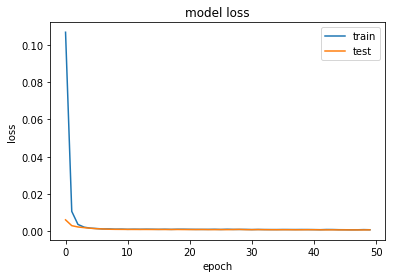

SCORE model 0.00020401724032126367


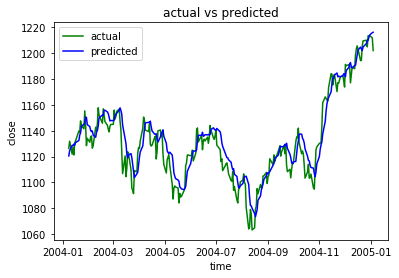

In [8]:
from aiconf import plot_model_performance, save_history_model
model = create_model(512, 'adam', 0.1, 'uniform')
model.summary()
history = model.fit(
        X_train, y_train, epochs=50, batch_size=64, 
        validation_data=(X_test, y_test), verbose=1, shuffle=True)

#0.00019193474133498967

plot_model_performance(history, model, close, X, y, TEST_SIZE)
#save_history_model(history, model, '/tmp/mlp_adam_512_0d1_uniform_300e')

## try a different model architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_175 (Dense)            (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 250 samples
Epoch 1/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0295 - val_loss: 0.0030
Epoch 2/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3/30
1000/1000 [==============================] - 2s 2ms/step - loss: 9.0826e-04 - val_loss: 0.0010
Epoch 4/30
1000/1000 [==============================] - 2s 2ms/step - loss: 9.3530e-04 - val_loss: 0.0013
Epoch 5/30
1000/1000 [==============================] - 1s 1ms/step -

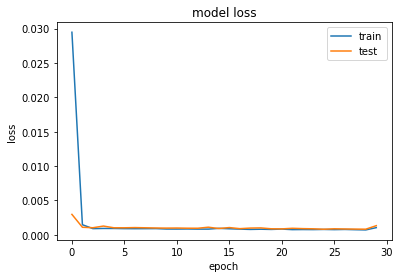

SCORE model 0.0004924075335729867


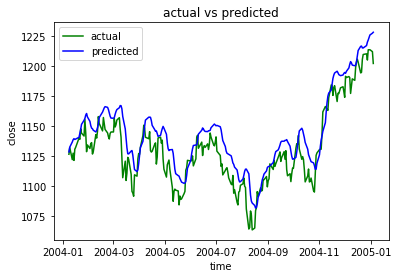

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from aiconf import plot_model_performance

model = Sequential()
model.add(LSTM(256, input_shape=(WINDOW,1)))
#model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

#Fit model with history to check for overfitting
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), shuffle=True)
score = model.evaluate(X_test, y_test)
print score

plot_model_performance(history, model, close, X, y, TEST_SIZE)

## MLP vs LSTM

MODEL:  /models/regression_mlp_300e


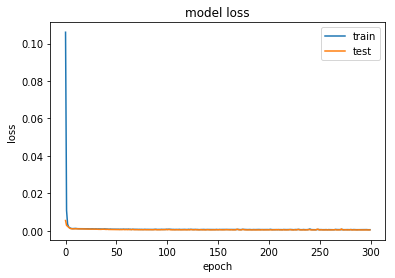

SCORE /models/regression_mlp_300e 0.00011454654962290078


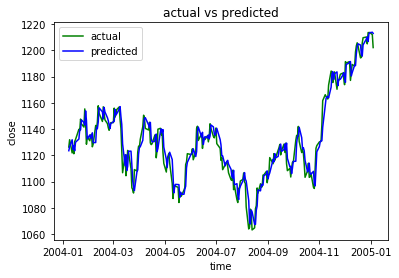

MODEL:  /models/regression_lstm_300e


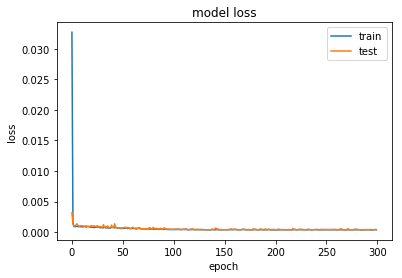

SCORE /models/regression_lstm_300e 0.0001845656658988446


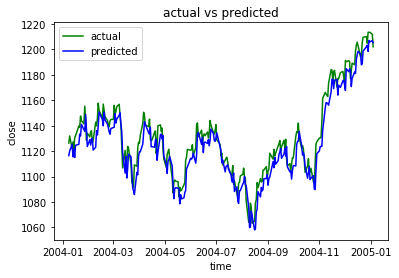

In [10]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from aiconf import fit_scaler, scale, prepare_regression_samples, plot_loaded_model_performance

WINDOW = 7
TEST_SIZE = 0.2

df = pd.read_csv('/data/historical-SP500.csv', index_col='Date', parse_dates=True).sort_index()
df = df[df.index.values > np.datetime64('2000-01-01')]
close = df['Close'][0:(1250+WINDOW+1)]
fit_scaler(close, TEST_SIZE)
sclose = scale(close).reshape(close.shape[0], 1)
X,y = prepare_regression_samples(sclose, WINDOW)

plot_loaded_model_performance('/models/regression_mlp_300e', close, X, y, TEST_SIZE, loss=True, score=True, predicted=True)
plot_loaded_model_performance('/models/regression_lstm_300e', close, X, y, TEST_SIZE, loss=True, score=True, predicted=True)